# Radio Modulation Classification with FINN - Notebook #2 of 5

### Overview 
In this Notebook we again load the dataset and create our dataloader. Then we:
1. Define our model using Brevitas
2. Train, and test our new Brevitas model!

Portions of this notebook that have been covered in the previous notebook will have much less description (such as the dataloader). The more information please see the Tutorial1_Dataset_and_Vanilla_model.ipynb file!

### FINN Pipeline Map
Throughout these notebooks, you will begin to understand the FINN pipeline! In order the pipeline is:
1. Dataset and Vanilla model
2. **Brevitas Model** (you are here)
3. Transforming the Brevitas Model to tidy.onnx
4. Transforming tidy.onnx to bitstream
5. Loading the bitstream on the FPGA!

We are in **2. Brevitas Model.** This notebook will show you how to define a VGG-10 model using the Brevitas Framework, which allows us to quantize the model (i.e make a smaller model). Having a quantized model is required for the next steps of the pipeline!


### Packages, and Data 
First we import the required packages and create the dataloader for the dataset. The details of this are explained in Notebook 1.

In [1]:
# Import required pacakages 
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm
import time

In [2]:
# Using cuda 
assert torch.cuda.is_available(), 'Cuda not available'
gpu = 'cuda'

In [3]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

## Load Dataset

In [4]:
#Parameter for dataloader

dataset_bit_width=8 #bit width of the raw dataset
model_input_bit=8 #bit width of quantized model

data_key='X'
mod_key='Y'
snr_key='Z'
snr_lower_bound=-20.0
snr_upper_bound=30.0
snr_steps=2.0
#If the original and target bit width are the same, then it will skip mapping the value

In [5]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        
        self.data = h5_file[data_key][:] 
        
        print('start quantizing dataset')
        self.quantize_bit(dataset_bit_width,model_input_bit)
        print('done quantizing dataset')
        
        self.mod = np.argmax(h5_file[mod_key], axis=1) # comes in one-hot encoding
        
        self.snr = h5_file[snr_key][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        self.snr_classes = np.arange(snr_lower_bound, snr_upper_bound+1.0, snr_steps) # -20dB to 30dB, with step of 2 --> 26 snrs or [0,25]

        np.random.seed(2021)

        train_indices = []
        test_indices = []
        val_indices = []

        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 25)
            for snr_idx in range(0, len(self.snr_classes)): # all SNRs (0 to 25 = -20dB to +30dB)
                start_idx = int(len(self.snr_classes))*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                # 80 10 10 split 
                split = int(np.ceil(0.8 * 4096)) 
                split2 = int(np.ceil(0.9 * 4096)) 

                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[:split]
                val_indices_subclass = indices_subclass[split:split2]
                test_indices_subclass = indices_subclass[split2:]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)

                test_indices.extend(test_indices_subclass)
                val_indices.extend(val_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)
        
    def quantize_bit(self, original_bit_width, target_bit_width):
        if original_bit_width==target_bit_width:
            print('original_bit_width already the same as target')
            return
        scale = (2 ** target_bit_width) - 1
        zero_center = 2 ** (target_bit_width - 1)
        
        # Normalize to [0, 1], scale to [0, 2^bit-1], shift to center around 0, then cast
        quantized = ((self.data.astype(np.float32) + 2**(original_bit_width-1)) / 2**original_bit_width)
        quantized*=scale
        quantized = np.round(quantized) - zero_center
    
        self.data = quantized.astype(np.int8) 
        
    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len


dataset = radioml_21_dataset(dataset_path) 
print('Value range: ', np.min(dataset.data),'   ',np.max(dataset.data),'  ',dataset.data.dtype) #The total range of int8 is [-127,128]
print('Total mods: ',dataset.num_classes)
print('Number of SNRs: ',len(dataset.snr_classes))
print('Number of frames per each SNR-Modulation combination: ',dataset.data.shape[0]/(dataset.num_classes*len(dataset.snr_classes)))
print('SNRs: ',dataset.snr_classes,' \n')
print('Total size: ',dataset.data.shape)
print('Training set size: ',len(dataset.train_sampler))
print('Val set size: ',len(dataset.val_sampler))
print('Test set size: ',len(dataset.test_sampler))

start quantizing dataset
original_bit_width already the same as target
done quantizing dataset
Value range:  -112     127    int8
Total mods:  27
Number of SNRs:  26
Number of frames per each SNR-Modulation combination:  4096.0
SNRs:  [-20. -18. -16. -14. -12. -10.  -8.  -6.  -4.  -2.   0.   2.   4.   6.
   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.  30.]  

Total size:  (2875392, 1024, 2)
Training set size:  2300454
Val set size:  287820
Test set size:  287118


# Build the VGG-10 model
This model is built with Brevitas (and Pytorch for non-parameters layers), meaning this model has already been quantized before training. 


## Brevitas Quantization at a Highlevel 

Brevitas _heavily abstracts_ the idea of quantizing and therefore gives us a lot of customization options! By definition quantizing is performing _some_ operation on a value to reduce it's precision. More informally, given some value that takes A bits to represent, change it to a new value that uses less than A bits to represent. 

Therefore, Brevitas is built upon the idea of defining **Custom Quantizers**. The quantizers are modules that allow the user to:
1. Select which parts {Weights, Bias, Input, Outputs} of a layer get quantized
2. The method by which each part of each layer is quantized {Custom, or defualts such as power of 2 quantization, scaled uniform, etc. brevitas defines _alot_ of quantization types}

Specifically, we can define 3 custom modules {WeightQuantType, BiasQuantType, ActQuantType}. The first two are used to quantize the Weights and Bias respectively, and the last one is used to quantize inputs and outputs of a layer. 


For example, below we use `Int8ActPerTensorFloatMinMaxInit` to define a ActQuantizer. This quantizer takes 3 parameters: bit_width, min_val, max_val. This will force corresponding tensors to have values between the min_val and max_val, and will be represented with bit_width bits.  

Formally, we define our quantizer as `InputQuantizer`, which inherits from `Int8ActPerTensorFloatMinMaxInit`. Meaning we can now use our quantizer **to enforce our quantizing rules** on a new layer! While verbose, you may now see the power we have to define very custom quantizers. 

Here is a tutorial to make your own quantizer: https://xilinx.github.io/brevitas/tutorials/anatomy_quantizer.html. 


#### Specifics 

**QuantRelu:** Implements a standard ReLu layer _followed_ by quantization 

**QuantConv1d:** This is an instance of both a standard Conv2d layer and QuantWeightBiasInputOutputLayer (QuantWBIOL) layer. A WBIOL layer is a layer that **allows for** quantizing of Weights, Bias, Inputs, and Outputs. Allow for, meaning, it does not by default enable quantization for all those layers, but if a user so wishes, they can choose to enable quantization for all those layers 

**QuantLinear:** Another WBIOL layer, this time combined with a Linear Layer. 


The default type of quantization for these layers is: Int8WeightPerTensorFloat, meaning the Wieghts are quantized to 8bit floats. However you can see in our implementation we specify a `weight_bit_width` and a `bias`. So we explicity set bias to false (which is redundant but good practice) and set weight_bit_width to a value that we can now customize! 


In [6]:
# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Adjustable hyperparameters
input_bits = model_input_bit #The same bit width as the new loaded dataset
a_bits = 8  # a_bits is the bit width for ReLu
w_bits = 8 # w_bits is the bit width for all the weights
filters_conv = 64
filters_dense = 128

#Signed value range of the input 
input_min_val=-2.0**(input_bits-1.0)
input_max_val=2.0**(input_bits-1.0)-1.0

build_dir="27ml_rf_8bit" #Directory to save model

In [7]:
chpt_path=Path(f'{build_dir}/model_brevitas.pth')
onnx_file=Path(f'{build_dir}/model_brevitas.onnx')

print(f'Model parameters will be saved in {chpt_path}')
print(f"input value has max range [{input_min_val}, {input_max_val}]")

Model parameters will be saved in 27ml_rf_8bit/model_brevitas.pth
input value has max range [-128.0, 127.0]


In [8]:
from torch import nn

# A qnn is a Brevitas version of pytorch's nn. nn stands for neural network.
import brevitas.nn as qnn
from brevitas.quant import Int8Bias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    #Quantize to input_bits
    bit_width = input_bits
    
    #Min max value of the input. Set to the range value of the input 
    min_val = input_min_val #the min value of the input(dataset) before going through the model
    max_val = input_max_val #the max value of the input(dataset) before going through the model
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

model_class = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits),

    qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

    qnn.QuantLinear(filters_dense, 27, weight_bit_width=w_bits, bias=True, bias_quant=Int8Bias),
)
model=model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

/usr/local/lib/python3.10/dist-packages/torch/_tensor.py:1255: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at ../c10/core/TensorImpl.h:1758.)
  return super(Tensor, self).rename(names)


Layer (type:depth-idx)                                            Output Shape              Param #
Sequential                                                        [1, 27]                   --
├─QuantHardTanh: 1-1                                              [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 2, 1024]              --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 2, 1024]              --
├─QuantReLU: 1-50                                                 --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-59                            --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-34                       --                        (recursive)
├─QuantHardTanh: 1-3                                              --                        --
│    └─ActQuantPro

# Train the model

In [9]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    # Save losses here and make sure model is in training mode.
    losses = []
    model.train()    

    # Iterate over the data and train
    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches"):#, leave=False):   
        #if gpu is not None:
        inputs = inputs.to('cuda')
        target = target.to('cuda')
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            #if gpu is not None:
            inputs = inputs.to('cuda')
            target = target.to('cuda')
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

We are training the model for 100 epochs with a batch size of 1024 by default.
These numbers can be adjusted. We use an early stop of 10 epochs

The first epoch usually takes longer to train. 
After that, it should train faster per epoch.

In [10]:
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup

batch_size = 1024
num_epochs = 100
early_stop = 10

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)
data_loader_val = DataLoader(dataset, batch_size=batch_size, sampler=dataset.val_sampler)

## Start Training

In [ ]:
model = model.to(gpu)

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)


running_loss = []
running_test_acc = []
training_time=time.time()
best_val_acc = float('-inf')
count = 0
for epoch in tqdm(range(num_epochs), desc="Epochs"):
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        val_acc = test(model, data_loader_val)
        print("Epoch %d: Training loss = %f, validation accuracy = %f" % (epoch, np.mean(loss_epoch), val_acc))

        if val_acc > best_val_acc:
            torch.save(model.state_dict(), chpt_path)
            print(f'Model checkpoint is saved in {chpt_path}')
    
            export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=onnx_file)
            qonnx_cleanup(str(onnx_file), out_file=str(onnx_file))
            print(f'QOnnx Model checkpoint is saved in {onnx_file}')
            best_val_acc = val_acc
            count = 0
        else:
            count+=1

        running_loss.append(loss_epoch)
        running_test_acc.append(val_acc)
        lr_scheduler.step()
    
        if count > early_stop:
            print("Stopping early")
            break

training_time=time.time()-training_time
print(f'total training time: {training_time}')

In [ ]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

In [ ]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

## Save the model parameters

In [ ]:
# Save the trained parameters to disk
torch.save(model.state_dict(), chpt_path)

## Or load a different model

In [ ]:
#Load the model back again, or you can change the file to load a different model
load_path=chpt_path #Change this to a path of a different model

model=model_class 
model.load_state_dict(torch.load(load_path))
model.to('cuda')

# Evaluate Accuracy

In [12]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        inputs = inputs.to(gpu).float()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/281 [00:00<?, ?it/s]

## Confusion Matrix across all SNRs

Overall Accuracy across all SNRs: 0.631145


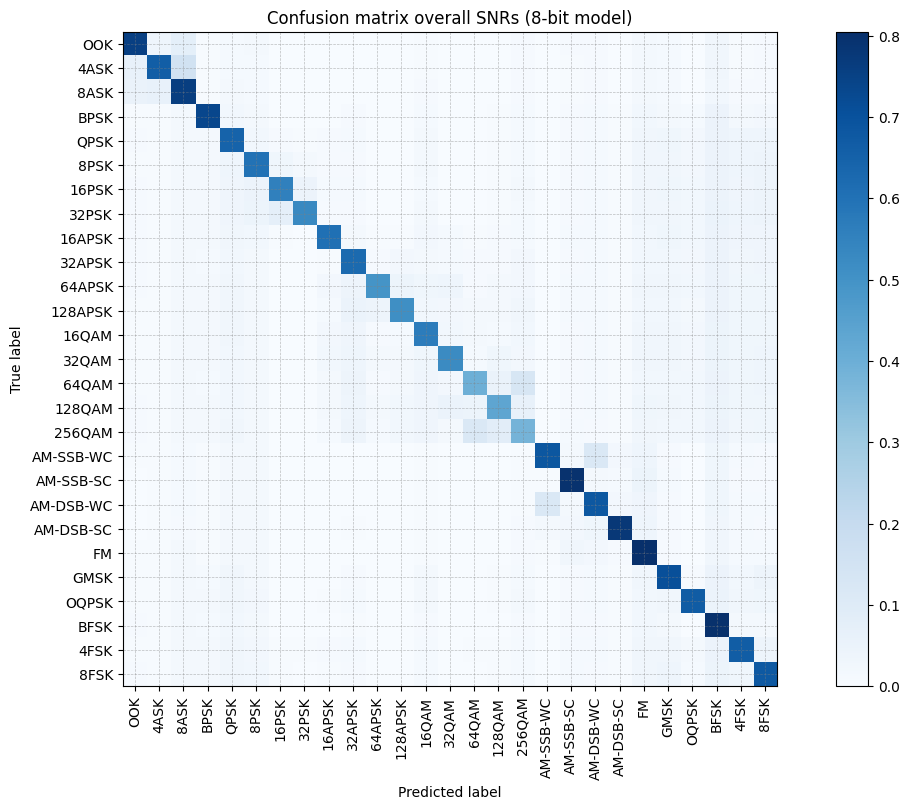

In [50]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title=f'Confusion matrix overall SNRs ({model_input_bit}-bit model)', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

## Confusion Matrix at 4 specific SNRs
Notice how the accuracy is very low at lower SNR and the accuracy is very high at higher SNR

<Figure size 1600x1000 with 0 Axes>

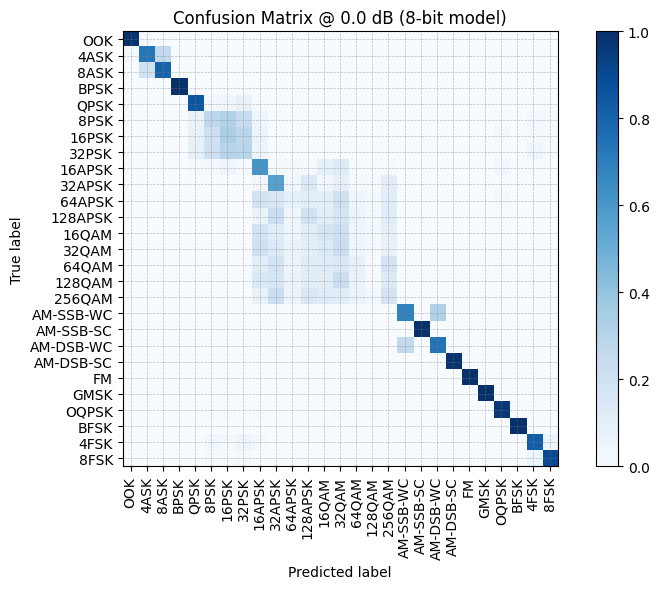

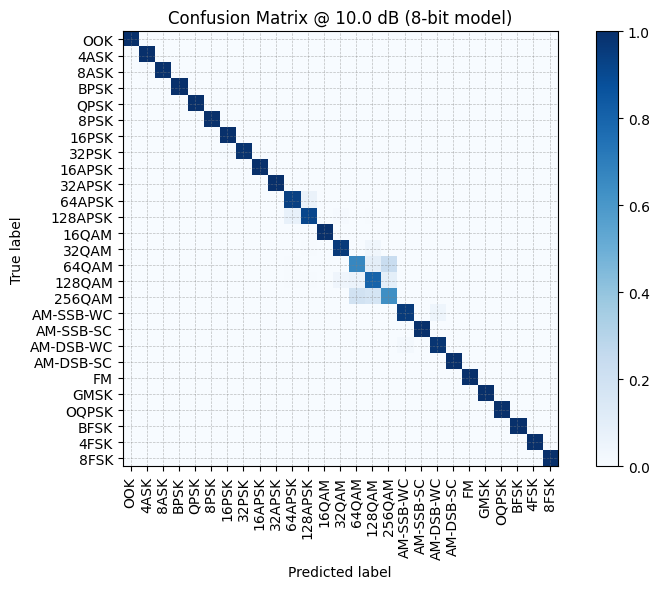

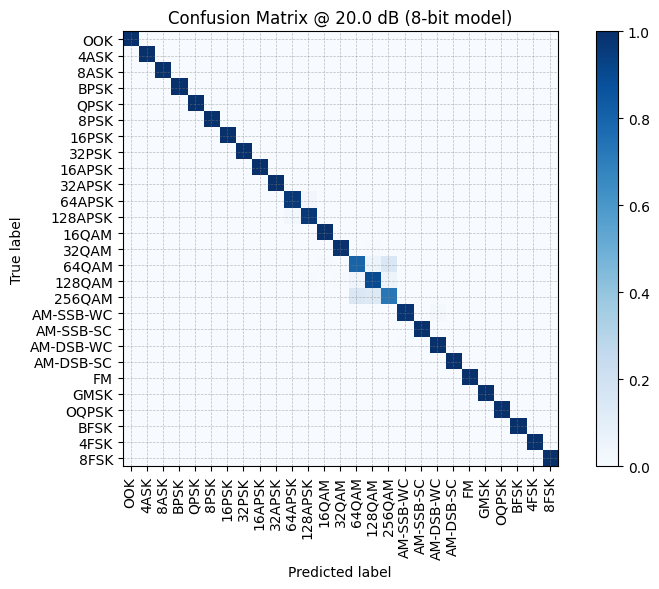

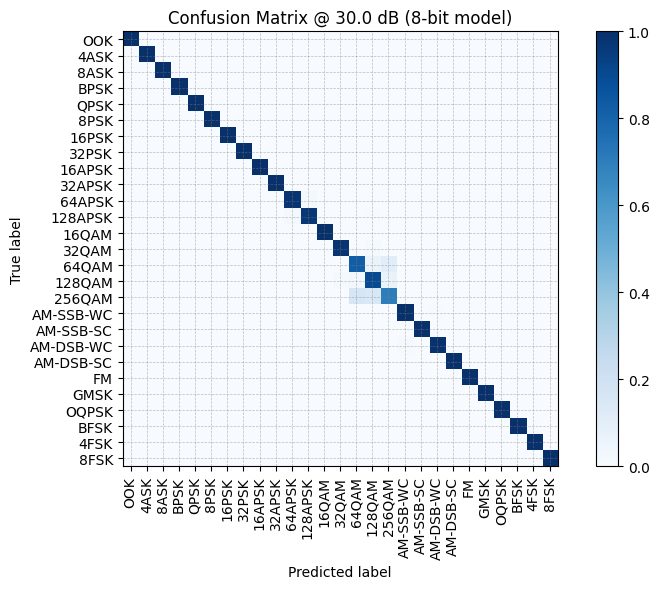

In [51]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [0,10,20,30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

    #Plot all matrices in 1 figure
    # if snr in snr_to_plot:
    #     plot, = np.where(snr_to_plot == snr)[0]
    #     plt.subplot(221+plot)
    #     plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
    
    # Plot each SNR in a separate figure
    if snr in snr_to_plot:
        plt.figure(figsize=(8, 6))
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title=f"Confusion Matrix @ {snr} dB ({model_input_bit}-bit model)")
        plt.tight_layout()
        plt.show()
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

## Accuracy over SNRs

Accuracy @ highest SNR (30.0 dB): 0.975188
Accuracy overall: 0.631145
SNR [-20]: 0.036584261523136825
SNR [-18]: 0.037942588064837454
SNR [-16]: 0.0471792085484017
SNR [-14]: 0.05541972290138549
SNR [-12]: 0.08811011500498053
SNR [-10]: 0.14362039300914606
SNR [-8]: 0.22312777325002264
SNR [-6]: 0.3012768269491986
SNR [-4]: 0.38060309698451505
SNR [-2]: 0.4877297835733044
SNR [0]: 0.6095263968124603
SNR [2]: 0.6952820791451598
SNR [4]: 0.7905460472697636
SNR [6]: 0.8816444806664856
SNR [8]: 0.9379697545956714
SNR [10]: 0.95653355066558
SNR [12]: 0.9692112650547858
SNR [14]: 0.9728334691659875
SNR [16]: 0.9737390201937879
SNR [18]: 0.9727429140632075
SNR [20]: 0.974010685502128
SNR [22]: 0.9736484650910079
SNR [24]: 0.9756406773521688
SNR [26]: 0.9750067916327085
SNR [28]: 0.9746445712215883
SNR [30]: 0.9751879018382685


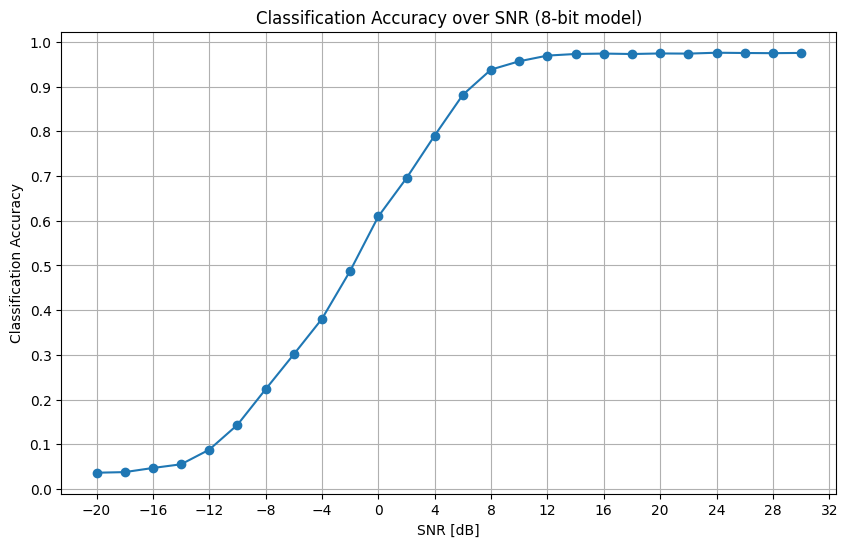

In [52]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xticks(np.arange(snr_lower_bound, snr_upper_bound+2.0*snr_steps, 2.0*snr_steps))
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(f"Classification Accuracy over SNR ({model_input_bit}-bit model)")
plt.grid()
# plt.title("Classification Accuracy over SNR");

print(f"Accuracy @ highest SNR ({snr_upper_bound} dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))
for i, a in enumerate(acc):
    print(f"SNR [{-20 + 2*i}]: {a}")

## Breakdown of the accuracy of each modulations over SNRs

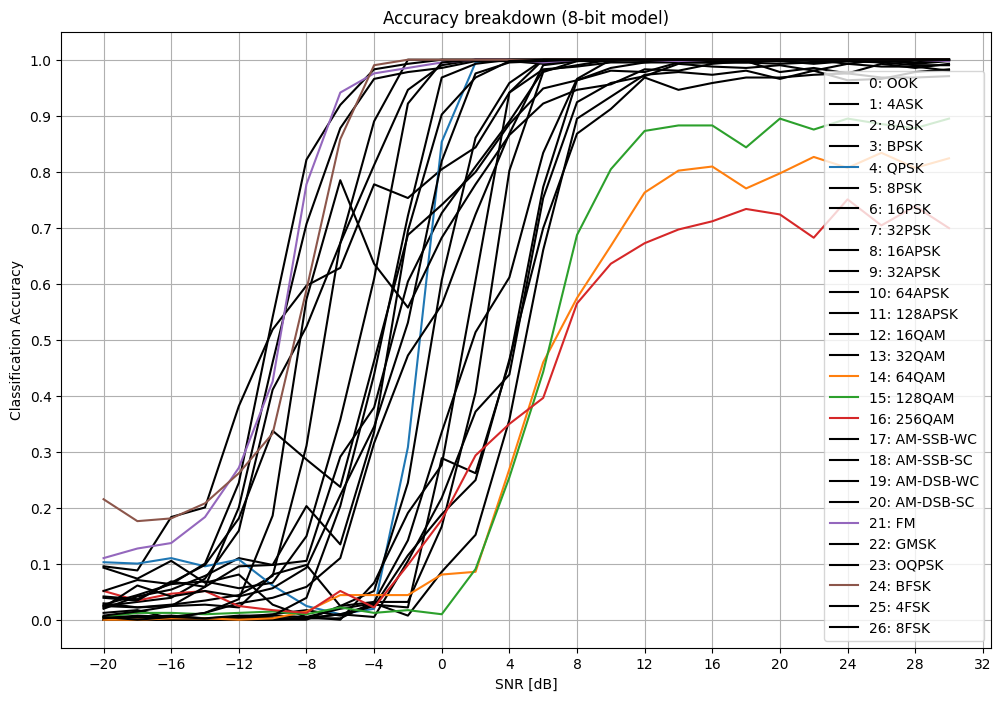

In [53]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xticks(np.arange(snr_lower_bound, snr_upper_bound+2.0*snr_steps, 2.0*snr_steps))
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title(f"Accuracy breakdown ({model_input_bit}-bit model)")
plt.grid()
plt.legend();

## Export model as QONNX (Quantized ONNX) file

QONNX is just a extended version of ONNX file. 

QONNX file is still saved under the extension `.onnx`, but their parameters are quantized

To standardize the project, we will call:
- QONNX Model exported from Brevitas: `_brevitas.onnx`
- QONNX Model after network surgery: `_finn.onnx`

Further information about FINN-ONNX and network surgery is explained in the `build_transformed_model.ipynb`

### Clean up the model so that FINN can regconize nodes

Ensure the model is cleaned up before converting to FINN ONNX, so that the nodes in the model are correctly labeled. Otherwise, when we convert to FINN-ONNX, the converter may not be able to regconize the nodes.

Source code for cleanup(): https://github.com/fastmachinelearning/qonnx/blob/main/src/qonnx/util/cleanup.py

In [55]:
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from brevitas.export import export_qonnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup

model.eval()

#Ensuring path exist, otherwise create an empty directory
Path(f"{build_dir}/onnx_models/").mkdir(exist_ok=True)
export_path=f"{build_dir}/onnx_models/radio_27ml_brevitas.onnx" #Full name of the path of the model with the tail _export.onnx
export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=export_path);

qonnx_cleanup(export_path, out_file=export_path)
print(f'model is saved in {export_path}')

model is saved in 27ml_rf_8bit/onnx_models/radio_27ml_brevitas.onnx
